# Campos y potenciales

## Poteciales y campos eléctricos: la ecuación de Laplace

En regiones donde no hay cargas eléctricas, el potecial eléctrico obedece la ecuación de Laplace:

$\nabla^2 V(x, y, z) = 0$

En esta ocasión tenemos que tener ciertas condiciones de frontera para $V(x,y,z)$ en el espacio. Satisfaces las condiciones de frontera no es tan fácil como satisfacer las condiciones iniciales de una ODE.

No hay métodos genéricos para PDE como sí lo hay para ODE's como RK o Euler, en realidad tenemos una variedad de algoritmos que se ajustan a ciertos tipos de ecuaciones parciales. 

Usaremos el **método de relajación** el cual es útil para *ecuaciones parciales elípticas*, categoría a la cual pertenece la ecuación de Laplace. 

Discretizamos las variables espaciales. Los puntos en el espacio se especifican por los enteros $i, j, k$ donde:

$x = i \Delta x, \qquad y = i \Delta y, \qquad z = i \Delta z$

Nosotros buscamos encontrar el potencial $V(i, j, k) \equiv V(i\Delta x, j\Delta y, k\Delta z)$ en esta red de puntos. Primero reescribimos la ecuación como una ecuación de diferencias. Por ejemplo, en el punto $(i, j, k)$ la derivada com respecto a $x$ se puede aproximar como:

$\dfrac{\partial V}{\partial x} \approx  \dfrac{V(i+1, j, k) - V(i, j, k)}{\Delta x}$

Como sabemos esta es la diferencia hacia delante, pero también existe hacia atrás y central. 

$\dfrac{\partial V}{\partial x} \approx  \dfrac{V(i, j, k) - V(i-1, j, k)}{\Delta x}$

$\dfrac{\partial V}{\partial x} \approx  \dfrac{V(i+1, j, k) - V(i-1, j, k)}{2 \Delta x}$

Notemos que la diferencia hacia delante est+a centrada sobre la ubicación "imaginaría" $i+1/2$, mientras que la diferencia hacia atrás está centrada en $i - 1/2$.

Si aplicamos la misma idea de una diferencia finita pero con las primeras derivadas, podemos aproximar la segunda derivada coomo:

$\dfrac{\partial^2 V}{\partial x^2} \approx \dfrac{1}{\Delta x} \left[ \dfrac{\partial V}{\partial x}(i + \frac{1}{2}) - \dfrac{\partial V}{\partial x} (i - \frac{1}{2}) \right] = \dfrac{V(i+1, j, k) + V(i-1, j, k) - 2V(i, j, k)}{(\Delta x)^2}$

En caso de que $\Delta x = \Delta y = \Delta z$, podemos sustituir las tres segundas derivadas para las tres variables de acuerdo con la ecuación anterior y despejas $V(i, j , k)$ obteniendo:

$V(i, j, k) = \dfrac{1}{6}[V(i+1, j, k) + V(i-1, j, k) + V(i, j+1, k) + V(i, j-1, k) + V(i, j, k+1) + V(i, j, k-1)]$

En este caso, lo que vemos es que el potecial en cualquier punto es *el promedio de V en todos los puntos vecinos*. La solución $V(i, j, k)$ es la fución que logra satisfacer esta codición en todos los puntos de la región simultáneamente. 

## Implementeación numérica

Por unicidad, si queremos la solución debemos tener determinado el potencial en toda la frontera, eso es un avance. Pero requerimos el potencial de los vecinos de todos los puntos, no de todo el potencial. ¿Solución? Proponer una primera solución aproximada $V_0(i, j, k)$ la cual evidentemente no satisfacerá la ecuación en todos los puntos, pero la idea es usar esta primer conjetura para obtener una segunda mejorada, de ella obtener una tercera y así sucesivamente. 

Este proceso iterativo ocurre hasta que satisfaga algún criterio de covergencia. Este es el **método de relajación** y es útil en varias clases de PDE. Hay muchas formas de implemetar este método, y el descrito es un algoritmo conocido como **método de Jacobi**.

Aunque no lo describiremos, se sabe que incluso el algoritmo de relajación más simple (el método de Jacobi) trabaja razonablemente bien dada una conjetura inicial $V_0$ no muy mala.

### Potencial eléctrico en una caja cuadrada

Supongamos una caja cuadrada (infinita, por lo que no hay dependencia en z) sujeta a las siguientes condiciontes de frontera:

![](Caja.png)

$V(-1, y) = -1, \qquad V(1, y) = 1, \qquad V(x, -1) = V(x, 1)= -x$

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
from numerical import *
#%matplotlib widget #este era para gráficas interactivas pero no jala aquí :(


ModuleNotFoundError: ignored

In [ ]:
def Discretiza(X, Y, N=[10, 10]):
    """Discretiza el plano en la región x[x0, x1], Y en [y0, y1] en secciones
        N = [nx, ny]"""
    
    x = np.linspace(X[0], X[1], N[0])
    y = np.linspace(Y[0], Y[1], N[1])
    X, Y = np.meshgrid(x, y)
    V = np.zeros([N[0], N[1]])
    
    return  X, Y, V

In [ ]:
X = [-1, 1]
Y = [-1, 1]
nx = ny = 20
N = [nx, ny]

X, Y, V = Discretiza(X, Y, N)
#V

In [ ]:
def CC1(V, V0, V1, Vx):
    """
    Condiciones de contorno para la caja metálica.
    """
    #Establecemos las condiciones de contorno
    indicesCC = []
    nx = np.shape(V)[1]
    
    for i in range(nx):
        V[i, 0] =  V0          #V(x, -1) = -1
        indicesCC.append((i, 0))
        V[i, nx-1] = V1         #V(x, 1 ) =  1
        indicesCC.append((i, nx-1))
    
        V[0, i] = Vx(i)        #V(x, 1) =  x
        indicesCC.append((0, i))
        V[nx-1, i] = Vx(i)     #V(x, -1) = x
        indicesCC.append((nx-1, i))
    
    return V, indicesCC

In [ ]:
#Establecemos las condiciones de contorno
V0 = -1; V1 = 1
Vx = lambda x: V0 + ((V1 - V0) / (nx-1)) * x   #V(x, 1) = x

V, indicesCC = CC1(V, V0, V1, Vx)



In [ ]:
def Relaxation(V, indicesCC, err=1e-7, imax=1000):
    
    diff = 0.; iteracion=0   # Inicializamos
    V_next = V_old = V.copy()
    nx = np.shape(V)[1]; ny = np.shape(V)[0]

    #Este ciclo while realiza el método de Jacobi
    while True:
        
        # Los límites de los for se les quitan las 'orillas' para que cada punto tenga vecinos.
        for i in range(1, nx-1):
            for j in range(1, ny-1):
                #Filtramos los puntos no definidos por las CC
                if (i, j) in indicesCC:
                    pass
                else: 
                    tmp= V_old[i, j]
                    #Se promedia como el método lo especifica
                    V_next[i, j] = (V_old[i+1, j] + V_old[i-1, j] + V_old[i, j-1] + V_old[i, j+1])/4.
                    #print(V_next[i, j], V_old[i, j])
                    #Cada punto contribuye con error, el cual se va sumando 
                    diff += np.abs( tmp - V_next[i, j])
            diff /= (2* nx +1)**2
        
        iteracion += 1
        if diff< err: #¿La diferencia de potencial es menor al mínimo establecido?
            print("Tolerancia de error mínima lograda. Err:", diff)
            break
            
        elif iteracion >= imax: #¿Se alcanzó el límite de iteraciones?
            print("Límite de iteraciones alcanzado:", iteracion)
            break
            
        else:
            #Redefinimos los arreglos para que funcione la iteración (el nuevo es el viejo en la sig. iteración)
            V_old = V_next.copy()
        
    return V_next, iteracion, diff

In [ ]:
V_next, iteracion, diff = RelaxationJacobi(V, indicesCC)


Tolerancia de error mínima lograda. Err: 9.943772813514002e-08
Iteraciones:  348


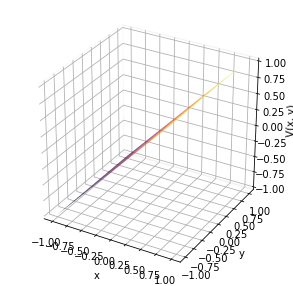

In [ ]:
Surface3D(X, Y, V_next)

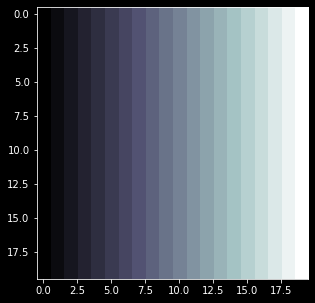

In [ ]:
Potencial(V_next)

Ahora calculemos el campo eléctrico, sabemos que el ecampo electrostático es producido por el gradiente de un potencial:

$\vec{E} = - \nabla V$

La derivada se puede aproximar por una diferencia central:

$E_x \approx  - \dfrac{V(i+1, j) - V(i-1, j) }{2 \Delta x }$

In [ ]:
def EField(V):
    #Electric field (x direction)
    nx = len(V[0, :]); ny = len(V[:, 0])
    
    Ex = np.zeros([nx, nx]); Ey = np.zeros([ny, ny])
    #Se calcula derivada con diferencia centrada
    for i in range(1, nx-1):
        for j in range(1, ny-1):
            Ex[i, j] = -(V[i+1, j] - V[i-1, j])/(2*(2/nx)) 
            Ey[i, j] = -(V[i, j+1] - V[i, j-1])/(2*(2/ny)) 
    
    return Ex, Ey

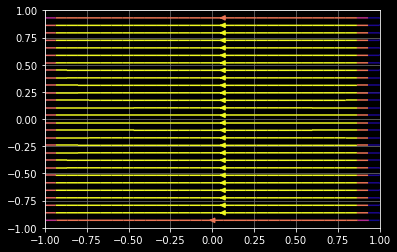

In [ ]:
Ex, Ey = EField(V_next)

x = X[0]
y = Y[:, 0]

PlotEField(x, y, Ex, Ey)


### Prisma  hueco con paredes metálicas y capas

Supongamos un prima hueco infinitamente largo con parede3s metalicas y una sección transversal cuadrada. Dentro del prisma hay una barra de metal con una sección transversal cuadrada.  El voltaje es aplicado entre la barra y las paredes exteriores, queremos el potencial entre ellos.

![](Prisma.png)




In [ ]:
X = [-1, 1]
Y = [-1, 1]
nx = ny = 30
N = [nx, ny]

X, Y, V = Discretiza(X, Y, N)


In [ ]:
def CC2(V):
    nx = len(V[0]); ny = len(V[:, 0])
    l = int(nx/4)
    indicesCC = []
    for i in range(l, nx -l):
        for j in range(l, ny -l):
            V[i, j]=1
            indicesCC.append((i, j))
    return V, indicesCC

In [ ]:
V, indicesCC = CC2(V)

In [ ]:
V_sol, iteracion, diff = Relaxation(V, indicesCC)


Tolerancia de error mínima lograda. Err: 9.997811430654308e-08


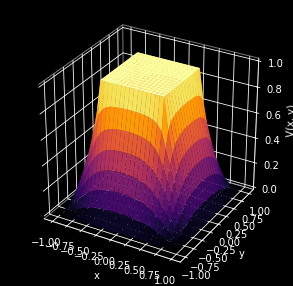

In [ ]:
Surface3D(X, Y, V_sol)

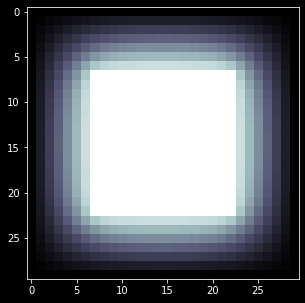

In [ ]:
Potencial(V_sol)

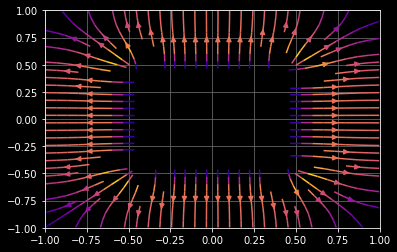

In [ ]:
Ex, Ey = EField(V_sol)

x = X[0]
y = Y[:, 0]

PlotEField(x, y, Ex, Ey)

### Capacitor de placas paralelas

In [ ]:
X = [-1, 1]
Y = [-1, 1]
nx = ny = 30
N = [nx, ny]

X, Y, V3 = Discretiza(X, Y, N)


In [ ]:
l=int(nx/4)

In [ ]:
indicesCC = []
for i in range(l, nx-l):
    V3[i, l] = -1
    indicesCC.append((i, l))
    V3[i, nx -l-1] = 1 
    indicesCC.append((i, nx-l-1))



In [ ]:
V_cap, iteracion, diff = RelaxationJacobi(V3, indicesCC)

Tolerancia de error mínima lograda. Err: 9.874150390459712e-08
Iteraciones:  371


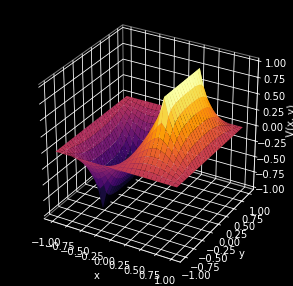

In [ ]:
Surface3D(X, Y, V_cap)


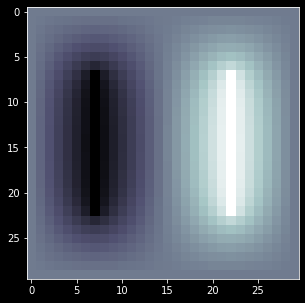

In [ ]:
Potencial(V_cap)

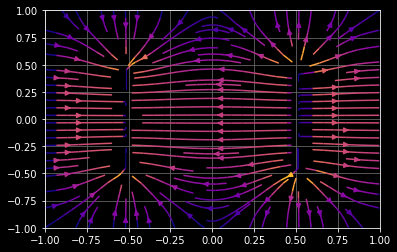

In [ ]:
Ex, Ey = EField(V_cap)

x = X[0]
y = Y[:, 0]

PlotEField(x, y, Ex, Ey)

### Convergencia del método de Jacobi y el método de Gauss-Seidel

Lamentablemente, el método de relajación de jacobi no tiene propiedades de convergencia muy buenas. 

Resulta que al ser aplicado a un problema en el plano, digamos, una cuadrícula de $L \times L$, el número de iteraciones requerido para convergencia es del orden de $L^2$. Esto es 'grave' ya que si se aumenta el número de puntos por un factor de 2, implica que la convergencia requerirá 4 veces más iteraciones.


Una mejora modesta es hecha con el método de Gauss-Seidel, el método implica todo lo anterior del método de Jacobi pero cambia la manera de iterar V, esto se resume a la siguiente ecuación:

$V_{next}(i, j) = \dfrac{1}{4}\left[ V_{old}(i+1, j) + V_{new}(i-1, j) + V_{old}(i, j+1) + V_{new}(i, j-1) \right]$

la mejora es modesta, pues solo reduce el número de iteraciones por un factor de 2. 

In [ ]:
def RelaxationGaussSeidel(V, indicesCC, err=1e-5, imax=10000):
    
    diff = 0.; iteracion=0   # Inicializamos
    V_next = V_old = V.copy()
    nx = np.shape(V)[1]; ny = np.shape(V)[0]

    #Este ciclo while realiza el método de Jacobi
    while True:
        
        # Los límites de los for se les quitan las 'orillas' para que cada punto tenga vecinos.
        for i in range(1, nx-1):
            for j in range(1, ny-1):
                #Filtramos los puntos no definidos por las CC
                if (i, j) in indicesCC:
                    pass
                else: 
                    #Se promedia como el método lo especifica
                    tmp = V_old[i, j]
                    V_next[i, j] = (V_next[i+1, j] + V_next[i-1, j] + V_next[i, j+1] + V_next[i, j-1])/4.
                    #print(V_next[i, j], V_old[i, j])
                    #Cada punto contribuye con error, el cual se va sumando 
                    diff += np.abs( tmp - V_next[i, j])
        diff /= (2* nx +1)**2
        
        iteracion += 1
        if diff< err: #¿La diferencia de potencial es menor al mínimo establecido?
            print("Tolerancia de error mínima lograda. Err:", diff)
            print("Iteraciones: ", iteracion)
            break
            
        elif iteracion >= imax: #¿Se alcanzó el límite de iteraciones?
            print("Límite de iteraciones alcanzado:", iteracion)
            break
            
        else:
            #Redefinimos los arreglos para que funcione la iteración (el nuevo es el viejo en la sig. iteración)
            V_old = V_next.copy()
        
    return V_next, iteracion, diff


Tolerancia de error mínima lograda. Err: 9.842305743975327e-06
Iteraciones:  122


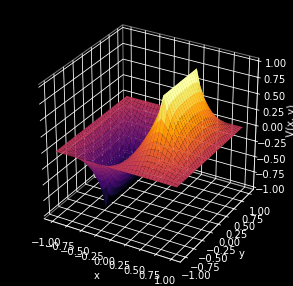

In [ ]:
#Capacitores con GaussSeidel
X = [-1, 1]
Y = [-1, 1]
nx = ny = 36
N = [nx, ny]

X, Y, V3 = Discretiza(X, Y, N)
l=int(nx/4)
indicesCC = []
for i in range(l, nx-l):
    V3[i, l] = -1
    indicesCC.append((i, l))
    V3[i, nx -l-1] = 1 
    indicesCC.append((i, nx-l-1))

V_cap, iteracion, diff = RelaxationGaussSeidel(V3, indicesCC)
Surface3D(X, Y, V_cap)




```
# Esto tiene formato de código
```

### Relajación sobresimultánea

Sea $V^* (i, j)$ el valor calculado por el método de Jacobi (o Gauss-Seidel), podemos pensar en la cantidad

$\Delta V(i, j) = V^*(i, j) - V_{old}(i, j)$

como el cambio recomenndado por el algoritmo de Jacobi (o Gauss-Seidel). Esta cantidad es muy conservativa, de modo que para acelerar la connvergencia podemos cambiar el potecial por:

$V_{new}(i, j) =  \alpha \Delta(i, j) + V_{old}(i, j)$

donde $\alpha$ es un factor que mide cuánto 'sobrerelajar':

* $\alpha = 1 \qquad \implies$ Método de Jacobi

* $\alpha\geq 2 \qquad \implies $ No hay convergencia

* $\alpha \in [1, 2] \qquad \implies$ Hay 'subrelajación'

El punto es determinar $\alpha$ tal que se obtenga una mayor convergencia, este valor depende de la geometría elegida, pero para una cuadrícula cuadrada la mejor elección es:

$\alpha \approx \dfrac{2}{1 + \pi/L}$

Este método ahora convierte que el número de iteraciones para convergencia sea del orden de $L$. 

In [ ]:
def SOR(V, indicesCC, err=1e-5, imax=100):
    iteracion=0; errores=[]  # Inicializamos
    V_next = V_GS= V.copy()
    ny, nx = np.shape(V)
    alpha = 2/(1 + np.pi/nx)
    termino=0.

    #Este ciclo while realiza el método de sobrerrejación
    while True:
        
        # Los límites de los for se les quitan las 'orillas' para que cada punto tenga vecinos.
        for i in range(1, nx-1):
            for j in range(1, ny-1):
                #Filtramos los puntos no definidos por las CC
                if (i, j) in indicesCC:
                    pass
                else: 
                    #Solución por Gauss-Seidel
                    tmp = V_next[i, j]   #Variable temporal para evitar mmdas
                    V_GS = (V_next[i+1, j] + V_next[i-1, j] + V_next[i, j+1] + V_next[i, j-1])/4. #Gauss-Seidel
                    ajuste = alpha*(V_GS - tmp) #Ajuste del método SOR
                    V_next[i, j] = ajuste + tmp  #SOR
                    #Se guarda el error por punto
                    error =abs(1 - V_GS/V_next[i,j])
                    errores.append(error)
        
        #El error será el máximo de los errores de cada punto
        errmax = max(errores)
        iteracion += 1        
        if errmax < err: #¿La diferencia de potencial es menor al mínimo establecido?
            print("Tolerancia de error mínima lograda. Err:", errmax)
            print("Iteraciones: ", iteracion)
            break

        elif iteracion >= imax: #¿Se alcanzó el límite de iteraciones?
            print("Límite de iteraciones alcanzado:", iteracion)
            break

        else:
            #Reiniciamos
            errores=[]
        
    return V_next, iteracion, errmax

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars


Tolerancia de error mínima lograda. Err: 8.000923949369465e-06
Iteraciones:  80


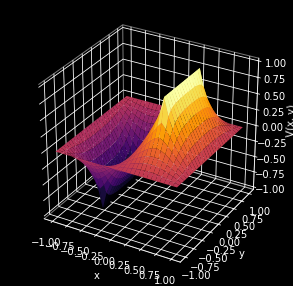

In [ ]:
#Capacitores con Relajaci[oin mmadisima
X = [-1, 1]
Y = [-1, 1]
nx = ny = 30
N = [nx, ny]

X, Y, V3 = Discretiza(X, Y, N)

l=int(nx/4)
indicesCC = []
for i in range(l, nx-l):
    V3[i, l] = -1
    indicesCC.append((i, l))
    V3[i, nx -l-1] = 1 
    indicesCC.append((i, nx-l-1))


V_cap, iteracion, diff = SOR(V3, indicesCC)
Surface3D(X, Y, V_cap)
